### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Using TensorFlow backend.


In [2]:
infile = open("../../tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)

### Read in a dataset file

In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

### Clean data row
Not implemented

In [5]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

### Get dataset
Loads all files from a directory

In [18]:
packet_count_threshold = 200
def get_dataset(path):
    out_data = []
    file = open('summary.out', 'w')
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = np.nan_to_num(read_in_file(temp_path))
            rows_before = temp_data.shape[0]
            if rows_before == 0:
                continue
            temp_data = temp_data[temp_data[:,2] > packet_count_threshold]
            rows_after = temp_data.shape[0]
            print (path + " removed " + str(rows_before-rows_after) + "/" + str(rows_before) + " rows")
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    file.close
    return out_data

### Load all datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [19]:
normal = get_dataset("../../DataSet/emulab/normal")
corr_01 = get_dataset("../../DataSet/emulab/corrupt_0.1perc")
corr_05 =  get_dataset("../../DataSet/emulab/corrupt_5perc")
corr_10 = get_dataset("../../DataSet/emulab/corrupt_1.0perc")
delay_1_1 = get_dataset("../../DataSet/emulab/delay_1_var_1")
delay_5_2 = get_dataset("../../DataSet/emulab/delay_5_var_2")
delay_10_5 = get_dataset("../../DataSet/emulab/delay_10_var_5")
delay_25_20 = get_dataset("../../DataSet/emulab/delay_25_var_20")
drop_1 = get_dataset("../../DataSet/emulab/loss_1_perc")
drop_2 = get_dataset("../../DataSet/emulab/loss_1perc")
drop_3 = get_dataset("../../DataSet/emulab/loss_5_perc")
drop_4 = get_dataset("../../DataSet/emulab/loss_5perc")
drop_5 = get_dataset("../../DataSet/emulab/loss_10perc")
drop_6 = get_dataset("../../DataSet/emulab/loss_10_perc")
drop_7 = get_dataset("../../DataSet/emulab/loss_15perc")
dup_1 = get_dataset("../../DataSet/emulab/dup_1perc")
dup_5 = get_dataset("../../DataSet/emulab/dup_5perc")
dup_7 = get_dataset("../../DataSet/emulab/dup_7perc")



l1  = np.ones(len(normal  ))    *1
l2  = np.ones(len(corr_01  ))   *2
l3  = np.ones(len(corr_05  ))   *2
l4  = np.ones(len(corr_10  ))   *2
l5  = np.ones(len(delay_1_1))   *3
l6  = np.ones(len(delay_5_2))   *3
l7  = np.ones(len(delay_10_5))  *3
l8  = np.ones(len(delay_25_20)) *3
l9  = np.ones(len(drop_1 ) )    *4
l10  = np.ones(len(drop_2 ) )   *4
l11  = np.ones(len(drop_3 ) )   *4
l12  = np.ones(len(drop_4 ) )   *4
l13  = np.ones(len(drop_5 ) )   *4
l14  = np.ones(len(drop_6 ) )   *4
l15  = np.ones(len(drop_7 ) )   *4
l16  = np.ones(len(dup_1))      *5
l17  = np.ones(len(dup_5))      *5
l18  = np.ones(len(dup_7))      *5



emulab_data = np.concatenate((normal, corr_01, corr_05, corr_10, delay_1_1, delay_5_2, delay_10_5, delay_25_20,
                           drop_1, drop_2, drop_3, drop_4, drop_5, drop_6, drop_7, dup_1, dup_5, dup_7))

pandas_emulab = pd.DataFrame(data=emulab_data, 
              columns=data_field_labels)
emulab_data = MinMaxScaler().fit_transform(pandas_emulab)


emulab_anom_type_data_labels = np.concatenate((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17, l18))
emulab_anom_type_data_labels = pd.DataFrame(data=emulab_anom_type_data_labels)
emulab_anom_type_data_labels = emulab_anom_type_data_labels.values.ravel()





normal = get_dataset("../../DataSet/hpc/normal")
corr_01 = get_dataset("../../DataSet/hpc/corrupt_0.1perc")
corr_05 = get_dataset("../../DataSet/hpc/corrupt_0.5perc")
corr_10 = get_dataset("../../DataSet/hpc/corrupt_1.0perc")
delay_1_1 = get_dataset("../../DataSet/hpc/delay_1_var_1")
delay_5_2 = get_dataset("../../DataSet/hpc/delay_5_var_2")
delay_10_5 = get_dataset("../../DataSet/hpc/delay_10_var_5")
delay_25_20 = get_dataset("../../DataSet/hpc/delay_25_var_20")
drop_01 = get_dataset("../../DataSet/hpc/loss_5perc")
drop_001 = get_dataset("../../DataSet/hpc/loss_10perc")
drop_0005 = get_dataset("../../DataSet/hpc/loss_15perc")
dup_1 = get_dataset("../../DataSet/hpc/dup_10perc")
dup_2 = get_dataset("../../DataSet/hpc/dup_20perc")

hpc_corrupt_001 = get_dataset("../../DataSet/hpc/corrupt_0.01")
hpc_corrupt_005 = get_dataset("../../DataSet/hpc/corrupt_0.05")
hpc_corrupt_01 = get_dataset("../../DataSet/hpc/corrupt_0.1")
hpc_corrupt_05 = get_dataset("../../DataSet/hpc/corrupt_0.5")
hpc_duplicate_001 = get_dataset("../../DataSet/hpc/duplicate_0.01")
hpc_duplicate_005 = get_dataset("../../DataSet/hpc/duplicate_0.05")
hpc_duplicate_01 = get_dataset("../../DataSet/hpc/duplicate_0.1")
hpc_duplicate_05 = get_dataset("../../DataSet/hpc/duplicate_0.5")
hpc_loss_001 = get_dataset("../../DataSet/hpc/loss_0.01")
hpc_loss_005 = get_dataset("../../DataSet/hpc/loss_0.05")
hpc_loss_01 = get_dataset("../../DataSet/hpc/loss_0.1")
hpc_loss_05 = get_dataset("../../DataSet/hpc/loss_0.5")



hpc_l1  = np.ones(len(hpc_normal  ))    *1
hpc_l2  = np.ones(len(hpc_corr_01  ))   *2
hpc_l3  = np.ones(len(hpc_corr_05  ))   *2
hpc_l4  = np.ones(len(hpc_corr_10  ))   *2
hpc_l5  = np.ones(len(hpc_corrupt_001  ))   *2
hpc_l6  = np.ones(len(hpc_corrupt_005  ))   *2
hpc_l7  = np.ones(len(hpc_corrupt_01  ))   *2
hpc_l8  = np.ones(len(hpc_corrupt_05  ))   *2
hpc_l9  = np.ones(len(hpc_delay_1_1))   *3
hpc_l10  = np.ones(len(hpc_delay_5_2))   *3
hpc_l11  = np.ones(len(hpc_delay_10_5))  *3
hpc_l12  = np.ones(len(hpc_delay_25_20)) *3
hpc_l13  = np.ones(len(hpc_drop_01))     *4
hpc_l14  = np.ones(len(hpc_drop_001))    *4
hpc_l15  = np.ones(len(hpc_drop_0005))   *4
hpc_l16  = np.ones(len(hpc_loss_001))   *4
hpc_l17  = np.ones(len(hpc_loss_005))   *4
hpc_l18  = np.ones(len(hpc_loss_01))   *4
hpc_l19  = np.ones(len(hpc_loss_05))   *4
hpc_l20  = np.ones(len(hpc_dup_1))       *5
hpc_l21  = np.ones(len(hpc_dup_2))       *5
hpc_l22  = np.ones(len(hpc_duplicate_001))       *5
hpc_l23  = np.ones(len(hpc_duplicate_005))       *5
hpc_l24  = np.ones(len(hpc_duplicate_01))       *5
hpc_l25  = np.ones(len(hpc_duplicate_05))       *5

hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_corrupt_001,hpc_corrupt_005,hpc_corrupt_01,hpc_corrupt_05,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_loss_001,hpc_loss_005,hpc_loss_01,hpc_loss_05,
                           hpc_dup_1, hpc_dup_2,hpc_duplicate_001,hpc_duplicate_005,hpc_duplicate_01,hpc_duplicate_005))

hpc_anom_type_data_labels = np.concatenate((hpc_l1, hpc_l2, hpc_l3, hpc_l4, hpc_l5, 
                                            hpc_l6, hpc_l7, hpc_l8, 
                                            hpc_l9, hpc_l10, hpc_l11, 
                                            hpc_l12, hpc_l13,hpc_l14, hpc_l15, hpc_l16, 
                                            hpc_l17, hpc_l18,hpc_l19,hpc_l20, 
                                            hpc_l21, hpc_l22,hpc_l23,hpc_l24,hpc_l25))

pandas_hpc = pd.DataFrame(data=hpc_data, 
              columns=data_field_labels)
hpc_data = MinMaxScaler().fit_transform(pandas_hpc)


hpc_anom_type_data_labels = pd.DataFrame(data=hpc_anom_type_data_labels)
hpc_anom_type_data_labels = hpc_anom_type_data_labels.values.ravel()


print(pandas_hpc.shape)
print(hpc_anom_type_data_labels.shape)

dtn_normal = get_dataset("../../DataSet/dtn/FINAL_DATA/normal")
dtn_normal2 = get_dataset("../../DataSet/dtn/DTN_LONG_DATA/normal")
dtn_corr_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc")
dtn_corr_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc")
dtn_corr_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc")
dtn_delay_1_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_1_var_1")
dtn_delay_5_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_5_var_2")
dtn_delay_10_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_10_var_5")
dtn_delay_25_20 = get_dataset("../../DataSet/dtn/FINAL_DATA/delay_25_var_20")
dtn_drop_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_1perc")
dtn_drop_5 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_5perc")
dtn_drop_10 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_10perc")
dtn_drop_15 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_15perc")
dtn_dup_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_0.1perc")
dtn_dup_1 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_1perc")
dtn_dup_2 = get_dataset("../../DataSet/dtn/FINAL_DATA/dup_2perc")

dtn_corrupt_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.01")
dtn_corrupt_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.05")
dtn_corrupt_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.1")
dtn_corrupt_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/corrupt_0.5")
dtn_duplicate_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.01")
dtn_duplicate_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.05")
dtn_duplicate_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.1")
dtn_duplicate_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/duplicate_0.5")
dtn_loss_001 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.01")
dtn_loss_005 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.05")
dtn_loss_01 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.1")
dtn_loss_05 = get_dataset("../../DataSet/dtn/FINAL_DATA/loss_0.5")


l1  = np.ones(len(dtn_normal  ) + len(dtn_normal2)) *1
l2  = np.ones(len(dtn_corr_01  ))   *2
l3  = np.ones(len(dtn_corr_05  ))   *2
l4  = np.ones(len(dtn_corr_10  ))   *2
l5  = np.ones(len(dtn_corrupt_001  ))  *2
l6  = np.ones(len(dtn_corrupt_005  ))  *2
l7  = np.ones(len(dtn_corrupt_01  ))   *2
l8  = np.ones(len(dtn_corrupt_05  ))   *2
l9  = np.ones(len(dtn_delay_1_1))   *3
l10  = np.ones(len(dtn_delay_5_2))   *3
l11  = np.ones(len(dtn_delay_10_5))  *3
l12  = np.ones(len(dtn_delay_25_20)) *3
l13  = np.ones(len(dtn_drop_01 ) ) *4
l14  = np.ones(len(dtn_drop_5) )   *4
l15  = np.ones(len(dtn_drop_10) )  *4
l16 = np.ones(len(dtn_drop_15) )   *4
l17  = np.ones(len(dtn_loss_001))  *4
l18  = np.ones(len(dtn_loss_005))  *4
l19  = np.ones(len(dtn_loss_01))   *4
l20  = np.ones(len(dtn_loss_05))   *4
l21  = np.ones(len(dtn_dup_01))    *5
l22  = np.ones(len(dtn_dup_1))     *5
l23  = np.ones(len(dtn_dup_2))     *5
l24  = np.ones(len(dtn_duplicate_001)) *5
l25  = np.ones(len(dtn_duplicate_005))*5
l26  = np.ones(len(dtn_duplicate_01)) *5
l27  = np.ones(len(dtn_duplicate_05)) *5




dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_corrupt_001, dtn_corrupt_005, dtn_corrupt_01, dtn_corrupt_05, 
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_5, dtn_drop_10, dtn_drop_15, dtn_loss_001,
                           dtn_loss_005, dtn_loss_01, dtn_loss_05,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2,dtn_duplicate_001,
                           dtn_duplicate_005, dtn_duplicate_01, dtn_duplicate_05,))



pandas_dtn = pd.DataFrame(data=dtn_data, 
              columns=data_field_labels)
dtn_data = MinMaxScaler().fit_transform(pandas_dtn)


dtn_anom_type_data_labels = np.concatenate((l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14,l15,
                                           l16, l17, l18, l19, l20, l21,l22, l23, l24,l25,l26,l27))
dtn_anom_type_data_labels = pd.DataFrame(data=dtn_anom_type_data_labels)
dtn_anom_type_data_labels = dtn_anom_type_data_labels.values.ravel()


print(pandas_dtn.shape)
print(dtn_anom_type_data_labels.shape)



../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/normal removed 119/238 rows
../../DataSet/emulab/corrupt_0.1perc removed 119/190 rows
../../DataSet/emulab/corrupt_0.1perc removed 119/238 rows
../../DataSet/emulab/corrupt_0.1perc removed 118/236 rows
../../DataSet/emulab/corrupt_0.1perc removed 119/238 rows
../../DataSet/emulab/corrupt_0.1perc removed 119/238 rows
../../DataSet/emulab/corrupt_5perc removed 121/235 rows
../../DataSet/emulab/corrupt_5perc removed 120/233 rows
../../DataSet/emulab/corrupt_5perc removed 94/147 rows
../../DataSet/emulab/corrupt_5perc removed 99/165 rows
../../DataSet/emulab/corrupt_5perc removed 121/202 rows


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


../../DataSet/emulab/corrupt_1.0perc removed 104/207 rows
../../DataSet/emulab/corrupt_1.0perc removed 119/239 rows
../../DataSet/emulab/corrupt_1.0perc removed 119/236 rows
../../DataSet/emulab/corrupt_1.0perc removed 119/193 rows
../../DataSet/emulab/corrupt_1.0perc removed 119/235 rows
../../DataSet/emulab/delay_1_var_1 removed 117/192 rows
../../DataSet/emulab/delay_1_var_1 removed 118/189 rows
../../DataSet/emulab/delay_1_var_1 removed 118/195 rows
../../DataSet/emulab/delay_1_var_1 removed 118/188 rows
../../DataSet/emulab/delay_1_var_1 removed 118/190 rows
../../DataSet/emulab/delay_5_var_2 removed 117/224 rows
../../DataSet/emulab/delay_5_var_2 removed 119/210 rows
../../DataSet/emulab/delay_5_var_2 removed 118/207 rows
../../DataSet/emulab/delay_5_var_2 removed 115/199 rows
../../DataSet/emulab/delay_5_var_2 removed 118/210 rows
../../DataSet/emulab/delay_10_var_5 removed 118/201 rows
../../DataSet/emulab/delay_10_var_5 removed 119/192 rows
../../DataSet/emulab/delay_10_var_5 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


../../DataSet/hpc/corrupt_0.5perc removed 1069/1413 rows
../../DataSet/hpc/corrupt_0.5perc removed 1083/1436 rows
../../DataSet/hpc/corrupt_0.5perc removed 436/436 rows
../../DataSet/hpc/corrupt_1.0perc removed 1143/1483 rows
../../DataSet/hpc/corrupt_1.0perc removed 1092/1445 rows
../../DataSet/hpc/corrupt_1.0perc removed 856/1054 rows
../../DataSet/hpc/corrupt_1.0perc removed 1007/1329 rows
../../DataSet/hpc/delay_1_var_1 removed 636/798 rows
../../DataSet/hpc/delay_1_var_1 removed 1270/1590 rows
../../DataSet/hpc/delay_5_var_2 removed 860/1103 rows
../../DataSet/hpc/delay_5_var_2 removed 1202/1552 rows
../../DataSet/hpc/delay_10_var_5 removed 596/763 rows
../../DataSet/hpc/delay_10_var_5 removed 1430/1793 rows
../../DataSet/hpc/delay_25_var_20 removed 582/717 rows
../../DataSet/hpc/delay_25_var_20 removed 1421/1769 rows
../../DataSet/hpc/loss_5perc removed 9/9 rows
../../DataSet/hpc/loss_5perc removed 2/2 rows
../../DataSet/hpc/loss_5perc removed 1202/1542 rows
../../DataSet/hpc/los

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 354/708 rows
../../DataSet/dtn/DTN_LONG_DATA/normal removed 18/36 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.1perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_0.5perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 12/24 rows
../../DataSet/dtn/FINAL_DATA/corrupt_1.0perc removed 11/23 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 7/13 rows
../../DataSet/dtn/FINAL_DATA/delay_1_var_1 removed 15/26 rows
../../DataSet/dtn/FINAL_DATA/delay_5_var_2 removed 10/18 rows
../../DataSet/dtn/FINAL_DATA/delay_5_var_2 removed 13/24 rows
../../DataSet/dtn/FINAL_DATA/delay_10_var_5 removed 14/25 rows
../../DataSet/dtn/FINAL_DATA/delay_10_var_5 removed 9/17 rows
../../DataSet/dtn/FINAL_DATA/delay_25_var_20 removed 4/7 rows
../.

In [20]:
all_data = np.concatenate((hpc_data,dtn_data,emulab_data))


all_anom_type_data_labels = np.concatenate((hpc_anom_type_data_labels,dtn_anom_type_data_labels,emulab_anom_type_data_labels))

all_anom_type_data_labels = pd.DataFrame(data=all_anom_type_data_labels)
all_anom_type_data_labels = all_anom_type_data_labels.values.ravel()



In [21]:
all_train_data, all_test_data, all_train_labels, all_test_labels = train_test_split(all_data, 
                                                                    all_anom_type_data_labels, random_state=seed)
all_train_data, all_train_labels = SMOTE().fit_resample(all_train_data, all_train_labels)

## DT:

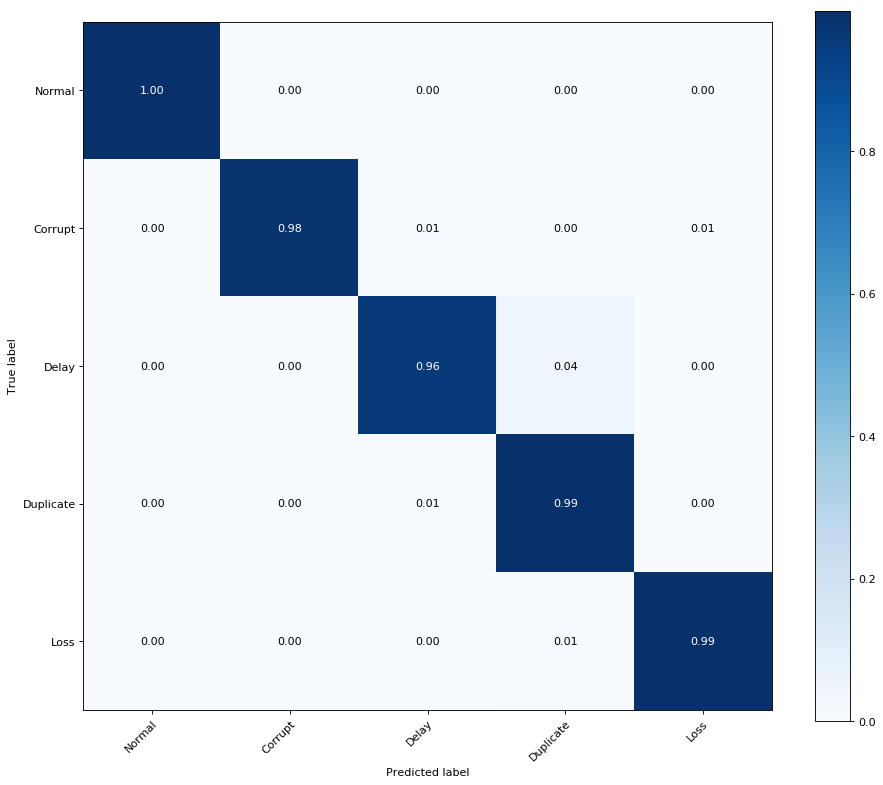

In [10]:
all_ = DecisionTreeClassifier()
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)

plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_DT.pdf')
plt.show()

report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_DT_CR.csv", sep='\t')

## RF :

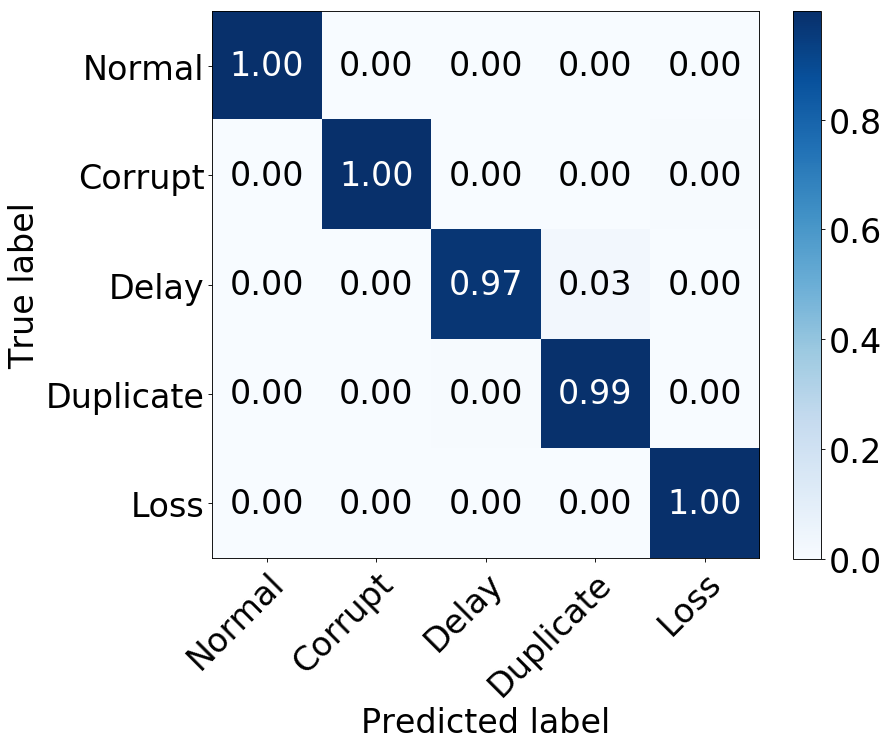

In [11]:
all_ =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)

plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_RF.pdf')
plt.show()
report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_RF_CR.csv", sep='\t')

## SVM :

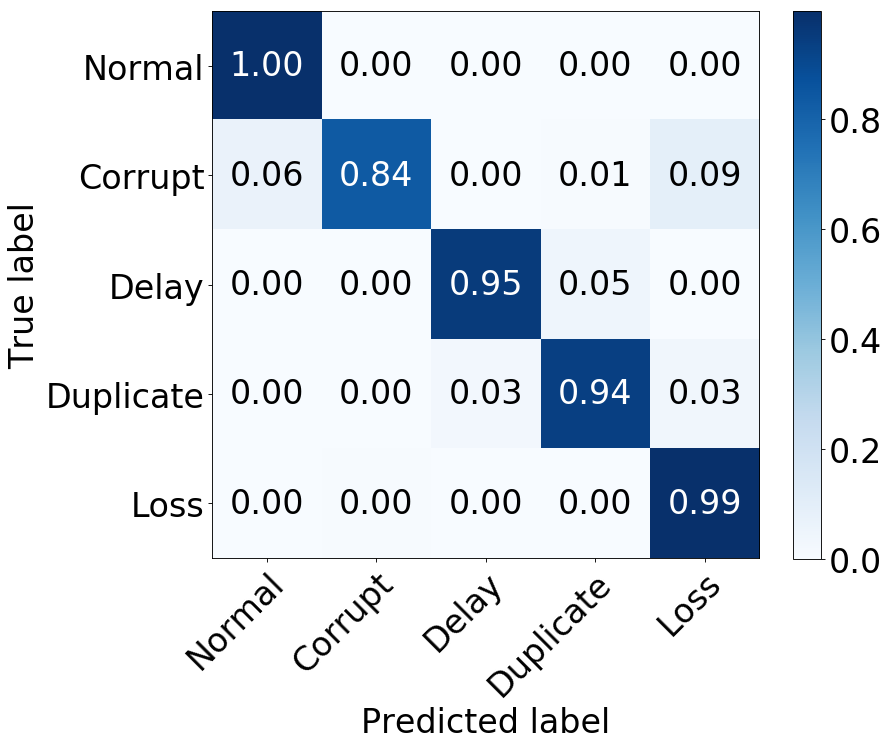

In [12]:
all_ = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)


plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_SVM.pdf')
plt.show()
report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_SVM_CR.csv", sep='\t')

# NN

Train on 35672 samples, validate on 8918 samples
Epoch 1/20
35672/35672 [==============================] - 3s 78us/step - loss: 0.3366 - accuracy: 0.8677 - val_loss: 0.1334 - val_accuracy: 0.9548
Epoch 2/20
35672/35672 [==============================] - 3s 73us/step - loss: 0.1597 - accuracy: 0.9331 - val_loss: 0.1405 - val_accuracy: 0.9320
Epoch 3/20
35672/35672 [==============================] - 3s 78us/step - loss: 0.1240 - accuracy: 0.9454 - val_loss: 0.1274 - val_accuracy: 0.9400
Epoch 4/20
35672/35672 [==============================] - 3s 79us/step - loss: 0.1084 - accuracy: 0.9520 - val_loss: 0.1146 - val_accuracy: 0.9964
Epoch 5/20
35672/35672 [==============================] - 3s 75us/step - loss: 0.0987 - accuracy: 0.9557 - val_loss: 0.1280 - val_accuracy: 0.9378
Epoch 6/20
35672/35672 [==============================] - 3s 77us/step - loss: 0.0913 - accuracy: 0.9585 - val_loss: 0.1691 - val_accuracy: 0.9429
Epoch 7/20
35672/35672 [==============================] - 3s 82us/ste

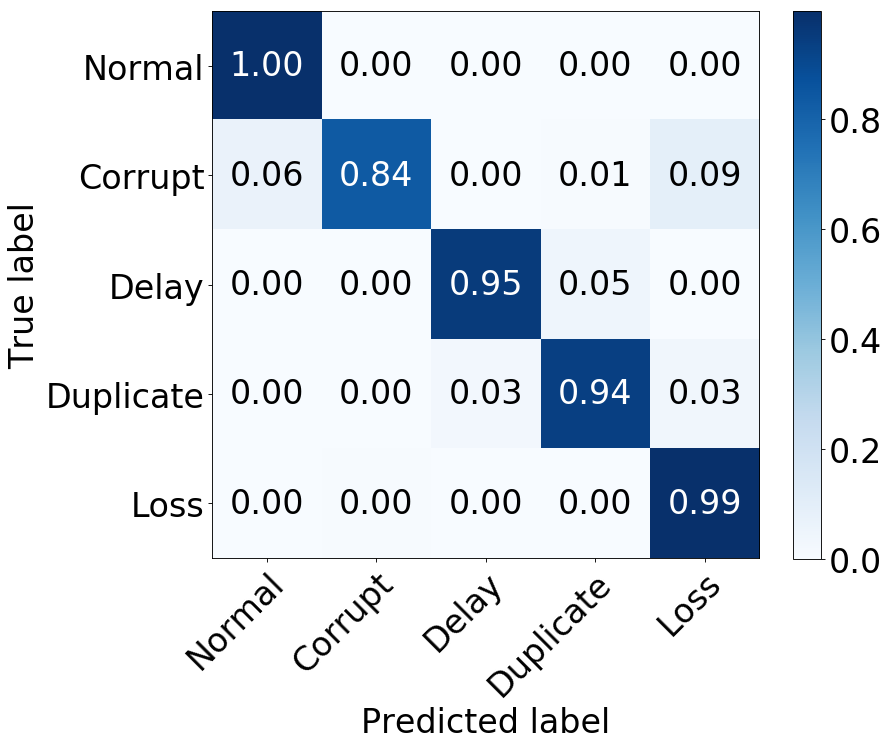

In [16]:

#create model
model = Sequential()

#get number of columns in training data
n_cols = all_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

all_train_labels_categorical = to_categorical(all_train_labels)

model.fit(all_train_data, all_train_labels_categorical, validation_split=0.2, epochs=20, callbacks=[early_stopping_monitor])
all_predicted_labels = all_.predict(all_test_data)


plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_NN.pdf')
plt.show()